In [0]:
%load_ext autoreload
%autoreload 2
# Enables autoreload; learn more at https://docs.databricks.com/en/files/workspace-modules.html#autoreload-for-python-modules
# To disable autoreload; run %autoreload 0

# Imports

In [0]:
!pip install pmdarima
dbutils.library.restartPython()

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from pyspark.sql import SparkSession
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
from pmdarima.utils import tsdisplay
import pmdarima as pm
import warnings
import pickle
import zipfile

from logger import log_message

# Loading

In [0]:
# Load Golden Layer data
base_path = "file:/Workspace/Users/masa.cirkovic@abo.fi/"
golden_path = base_path + "medallion/gold/golden_data"

golden_df = spark.read.format("delta").load(golden_path)
golden_pandas_df = golden_df.toPandas()

In [0]:
df = golden_pandas_df.copy()
df

,car_id,company_id,date,dealer_name,dealer_region,model,engine,transmission,color,body_style,price_$,company_name,company_type,founding_year,headquarters,name,gender,annual_income_$
0,C_CND_000995,CMP_006,2022-03-19,U-Haul CO,Austin,Montero Sport,Double Overhead Camshaft,Auto,Pale White,SUV,53000,Mitsubishi,private,1970,Japan,Addison,Female,13500
1,C_CND_002277,CMP_025,2022-05-07,Motor Vehicle Branch Office,Austin,Continental,Overhead Camshaft,Manual,Black,Passenger,18000,Lincoln,division,1917,United States,Perel,Male,520000
2,C_CND_003059,CMP_010,2022-06-09,Race Car Help,Austin,323i,Overhead Camshaft,Manual,Red,Hatchback,21000,BMW,private,1916,Germany,Alana,Male,515000
3,C_CND_003837,CMP_020,2022-07-10,Clay Johnson Auto Sales,Austin,LW,Double Overhead Camshaft,Auto,Pale White,Hatchback,18000,Saturn,division,1985,US,Alizee,Female,390000
4,C_CND_004266,CMP_008,2022-07-31,Clay Johnson Auto Sales,Austin,Pathfinder,Double Overhead Camshaft,Auto,Red,Hatchback,21000,Nissan,private,1933,Japan,Audrey,Male,1960000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23383,C_CND_019560,CMP_007,2023-10-14,Scrivener Performance Engineering,Greenville,Monte Carlo,Double Overhead Camshaft,Auto,Red,Hatchback,21000,Chevrolet,division,1911,United States,Zaire,Male,800000
23384,C_CND_021245,CMP_030,2023-11-19,Pars Auto Sales,Greenville,Wrangler,Double Overhead Camshaft,Auto,Pale White,Hatchback,19000,Jeep,division,1941,US,Abdullah,Male,611000
23385,C_CND_021352,CMP_007,2023-11-20,Gartner Buick Hyundai Saab,Greenville,Monte Carlo,Double Overhead Camshaft,Auto,Pale White,Hatchback,21001,Chevrolet,division,1911,United States,Avery,Male,760000
23386,C_CND_021626,CMP_013,2023-11-24,Gartner Buick Hyundai Saab,Greenville,Sonata,Overhead Camshaft,Manual,Black,SUV,20000,Hyundai,private,1967,South Korea,Laure,Male,2500000


# Data Processing

In [0]:
df['date']= pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,car_id,company_id,dealer_name,dealer_region,model,engine,transmission,color,body_style,price_$,company_name,company_type,founding_year,headquarters,name,gender,annual_income_$
date,,,,,,,,,,,,,,,,,
2022-03-19,C_CND_000995,CMP_006,U-Haul CO,Austin,Montero Sport,Double Overhead Camshaft,Auto,Pale White,SUV,53000,Mitsubishi,private,1970,Japan,Addison,Female,13500
2022-05-07,C_CND_002277,CMP_025,Motor Vehicle Branch Office,Austin,Continental,Overhead Camshaft,Manual,Black,Passenger,18000,Lincoln,division,1917,United States,Perel,Male,520000
2022-06-09,C_CND_003059,CMP_010,Race Car Help,Austin,323i,Overhead Camshaft,Manual,Red,Hatchback,21000,BMW,private,1916,Germany,Alana,Male,515000
2022-07-10,C_CND_003837,CMP_020,Clay Johnson Auto Sales,Austin,LW,Double Overhead Camshaft,Auto,Pale White,Hatchback,18000,Saturn,division,1985,US,Alizee,Female,390000
2022-07-31,C_CND_004266,CMP_008,Clay Johnson Auto Sales,Austin,Pathfinder,Double Overhead Camshaft,Auto,Red,Hatchback,21000,Nissan,private,1933,Japan,Audrey,Male,1960000


In [0]:
# Calculate number of sales for each date
x = np.ones(shape=len(df))
df.insert(0, 'Sales', x)
daily_df = df['Sales']
daily_df = daily_df.resample('D').sum()
daily_df

date
2022-01-02     35.0
2022-01-03     20.0
2022-01-04     15.0
2022-01-05     30.0
2022-01-06     10.0
              ...  
2023-12-27     35.0
2023-12-28      0.0
2023-12-29    150.0
2023-12-30     40.0
2023-12-31     35.0
Freq: D, Name: Sales, Length: 729, dtype: float64

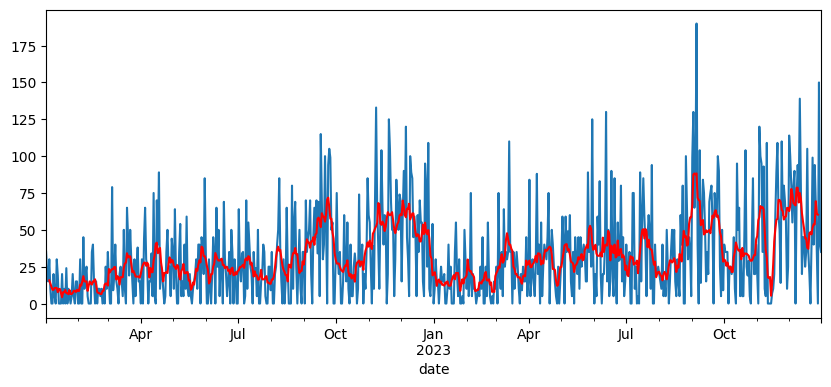

In [0]:
fig, ax = plt.subplots(figsize=(10,4))
daily_df.plot(kind='line', ax=ax)
# 7 days moving average 
daily_df.rolling(7, center=True).mean().plot(kind='line', color='red', ax=ax)
plt.show()

# Modeling

In [0]:
train = daily_df["2022-01":"2023-10"] 
valid = daily_df["2023-11":]

In [0]:
print("Train set length:",len(train))
print("Test set length:",len(valid))

Train set length: 668
Test set length: 61


/databricks/python/lib/python3.12/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


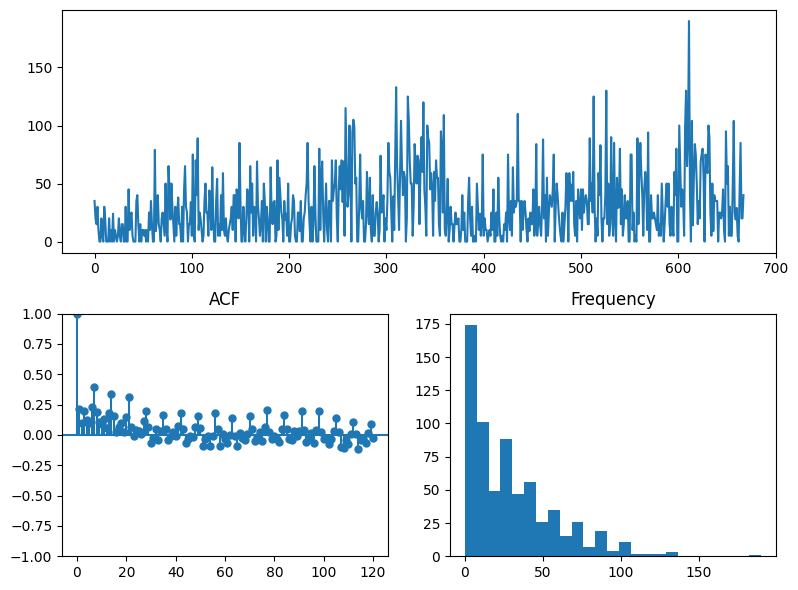

In [0]:
# Looking at data distribution and correlation to past values
tsdisplay(train, lag_max=120)

In [0]:
# Based on the visualizations, the data is not normally distributed.
# Thus, 'seasonal' parameter was set to True.

warnings.filterwarnings("ignore") 
arima_model = pm.auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True, 
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(arima_model.aic())

Performing stepwise search to minimize aic


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=14.31 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=6679.966, Time=4.89 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=6488.219, Time=6.84 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=8.18 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(0,0,0)(0,1,0)[12]             : AIC=6678.032, Time=5.21 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=6679.751, Time=5.26 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=6412.917, Time=10.13 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=10.61 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=7.45 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=6426.990, Time=11.22 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=6414.650, Time=13.42 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=18.64 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=6413.418, Time=14.54 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=23.33 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(1,0,0)(2,1,0)[12]             : AIC=6411.223, Time=10.80 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(1,0,0)(1,1,0)[12]             : AIC=6486.374, Time=7.50 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(1,0,0)(2,1,1)[12]             : AIC=inf, Time=12.76 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(1,0,0)(1,1,1)[12]             : AIC=inf, Time=8.71 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(0,0,0)(2,1,0)[12]             : AIC=6425.410, Time=10.25 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(2,0,0)(2,1,0)[12]             : AIC=6412.943, Time=11.01 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(1,0,1)(2,1,0)[12]             : AIC=inf, Time=16.29 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(0,0,1)(2,1,0)[12]             : AIC=6411.741, Time=10.20 sec


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=20.16 sec

Best model:  ARIMA(1,0,0)(2,1,0)[12]          
Total fit time: 261.779 seconds
6411.222519553797


In [0]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  668
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -3201.611
Date:                            Thu, 20 Mar 2025   AIC                           6411.223
Time:                                    11:30:47   BIC                           6429.167
Sample:                                01-02-2022   HQIC                          6418.180
                                     - 10-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1611      0.037      4.309      0.000       0.088       0.234
ar.S.L12      -0.6892      0.034    -19.991      0.000      -0.757      -0.622
ar.S.L24      -0.3345      0.033    -10.021      0.000      -0.400      -0.269
sigma2      1005.3609     47.134     21.330      0.000     912.980    1097.742
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                53.38
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.37   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 0, 'Days')

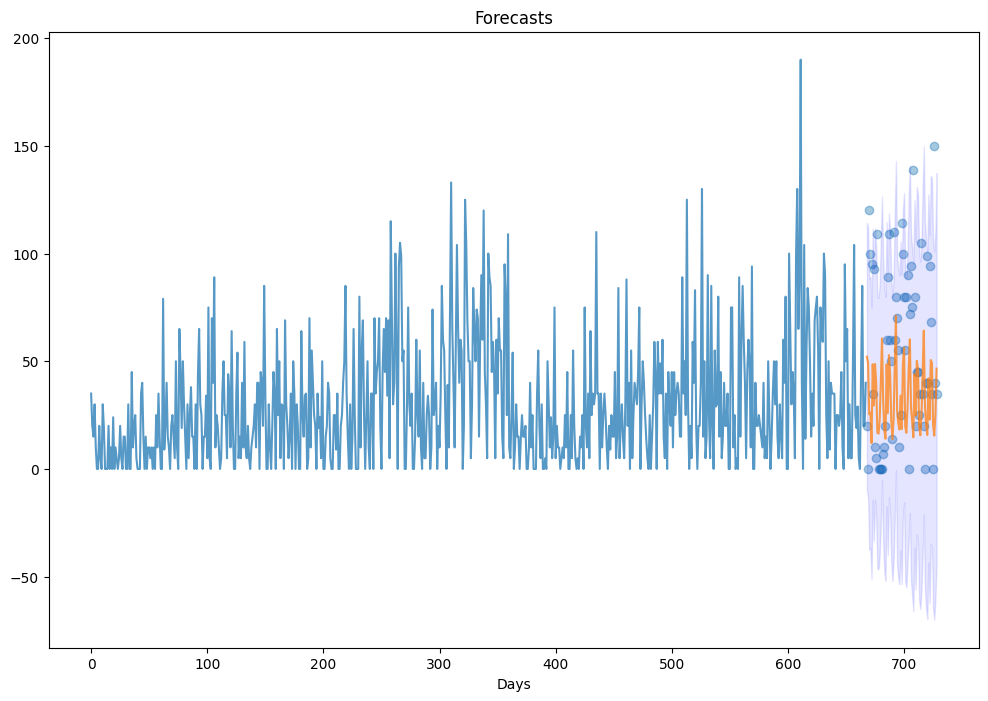

In [0]:
pred, conf_int = arima_model.predict(n_periods=valid.shape[0], return_conf_int=True)

# Visualization
x_axis = np.arange(train.shape[0] + pred.shape[0])
x_days = x_axis  
plt.figure(figsize=(12,8))
plt.plot(x_days[x_axis[:train.shape[0]]], train, alpha=0.75)
plt.plot(x_days[x_axis[train.shape[0]:]], pred, alpha=0.75)  
plt.scatter(x_days[x_axis[train.shape[0]:]], valid, alpha=0.4, marker='o')
plt.fill_between(x_days[x_axis[-pred.shape[0]:]],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.title("Forecasts")
plt.xlabel("Days")

<Axes: xlabel='date'>

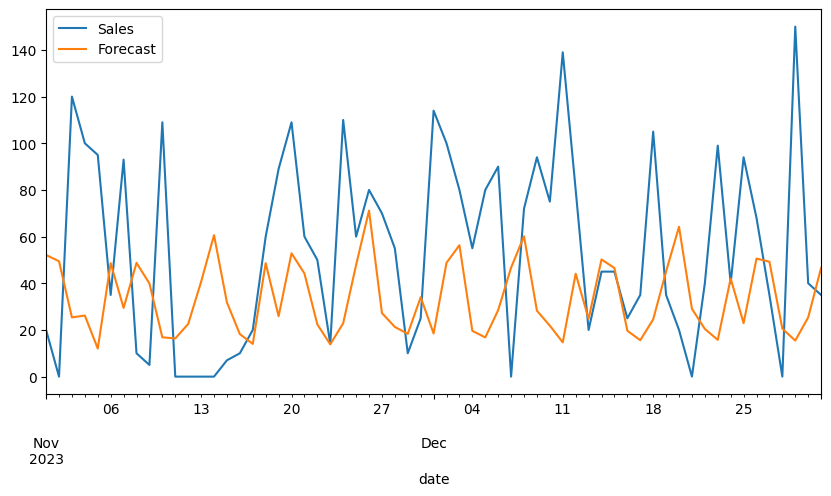

In [0]:
valid = valid.to_frame()
valid.insert(1, 'Forecast',pred)
fig , ax = plt.subplots( figsize=(10,5))
valid.plot(ax=ax)

Since the dataset is synthetic, model's performance is not the best. The model cannot find any trends or seasonality, meaning it is very uncertain about its predictions.

In [0]:
model_path = base_path.split("file:")[1] + "models/"
os.makedirs(model_path, exist_ok=True)
model_path += "arima_model.pkl"

# Save the trained ARIMA model
try:
    with open(model_path, "wb") as model_file:
        pickle.dump(arima_model, model_file)

    print(f"ARIMA model saved successfully at: {model_path}")

    log_message("info", "time_series_modeling", "saving arima model", "ARIMA model saved successfully")
except Exception as e:
    print(f"Error saving ARIMA model: {e}")
    log_message("error", "time_series_modeling", "saving arima model", f"Error saving ARIMA model: {e}")


ARIMA model saved successfully at: /Workspace/Users/masa.cirkovic@abo.fi/models/arima_model.pkl


In [0]:
zip_model_path = base_path.split("file:")[1] + "models/arima_model.zip"

try:
    with zipfile.ZipFile(zip_model_path, "w", compression=zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(model_path, arcname="arima_model.pkl")
    
    print(f"ARIMA model saved successfully at: {zip_model_path}")

    log_message("info", "time_series_modeling", "saving zip arima model", "ARIMA model ZIP saved successfully")
except Exception as e:
    print(f"Error saving ARIMA model: {e}")
    log_message("error", "time_series_modeling", "saving arima zip model", f"Error saving ARIMA ZIP model: {e}")

ARIMA model saved successfully at: /Workspace/Users/masa.cirkovic@abo.fi/models/arima_model.zip
